In [4]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
import pickle
import networkx as nx
import openne
import openne.node2vec
from openne.graph import *
import scipy.sparse as sp
import random
random.seed(32)
np.random.seed(32)

In [5]:
#有方法：degree_graph、load_net、getNodelist、save_sampledEdges、extract_edges、extractEdgesByRatioList

"""
功能: 统计网络的度分布
输入: networkx格式的图G
返回: 各节点度
"""
def degree_graph(G,savaPath="pictures/origin.svg"):
    # G = nx.from_scipy_sparse_matrix(adj_matrix)
    degree = G.degree()  # 返回所有节点的度
    sum_degree = 0
    for elem in degree:
        sum_degree += elem[1]
    avl_degree = sum_degree / len(degree)
    #print("网络平均度：" + str(round(avl_degree, 4)))
    degree_his = nx.degree_histogram(G)  # 返回图中所有节点的度分布序列
    # print(degree_his)
    x = range(len(degree_his))  # 生成x轴序列，从1到最大度
    # 将频次转换为频率，这用到Python的一个小技巧：列表内涵）
    y = [z / float(sum(degree_his)) for z in degree_his]  
    plt.title("The distribution of degree\nAverage degree:" + str(round(avl_degree, 4)))
    plt.loglog(x, y, "b.")  # 在双对数坐标轴上绘制度分布曲线color="blue", linewidth=2
    plt.savefig(savaPath)
    plt.show()
    plt.close()
    return degree

def degree_graph_chinese(G,savaPath="pictures/origin.svg"):
    # G = nx.from_scipy_sparse_matrix(adj_matrix)
    degree = G.degree()  # 返回所有节点的度
    sum_degree = 0
    for elem in degree:
        sum_degree += elem[1]
    avl_degree = sum_degree / len(degree)
    #print("网络平均度：" + str(round(avl_degree, 4)))
    degree_his = nx.degree_histogram(G)  # 返回图中所有节点的度分布序列
    # print(degree_his)
    x = range(len(degree_his))  # 生成x轴序列，从1到最大度
    # 将频次转换为频率，这用到Python的一个小技巧：列表内涵）
    y = [z / float(sum(degree_his)) for z in degree_his]  
    plt.title("网络的度分布图\n平均度为:" + str(round(avl_degree, 4)))
    plt.loglog(x, y, "b.")  # 在双对数坐标轴上绘制度分布曲线color="blue", linewidth=2
    plt.savefig(savaPath)
    plt.show()
    plt.close()
    return degree

"""
功能: 统计网络的度分布
输入: networkx格式的图G
返回: 各节点度
"""
def getDegree(G,savaPath="pictures/degreeDistribute.svg"):
    # G = nx.from_scipy_sparse_matrix(adj_matrix)
    degree = G.degree()  # 返回所有节点的度
    sum_degree = 0
    for elem in degree:
        sum_degree += elem[1]
    avl_degree = sum_degree / len(degree)
    #print("网络平均度：" + str(round(avl_degree, 4)))
    degree_his = nx.degree_histogram(G)  # 返回图中所有节点的度分布序列
    # print(degree_his)
    x = range(len(degree_his))  # 生成x轴序列，从1到最大度
    # 将频次转换为频率，这用到Python的一个小技巧：列表内涵）
    y = [z / float(sum(degree_his)) for z in degree_his]  
    plt.title("The distribution of degree\nAverage degree:" + str(round(avl_degree, 4)))
    plt.loglog(x, y, "b.")  # 在双对数坐标轴上绘制度分布曲线color="blue", linewidth=2
    plt.savefig(savaPath)
    plt.show()
    plt.close()
    return degree

"""
#name2index：节点ID与标号对应表
功能: 添加网络
输入: 
    fileName:文件名
    start_index:开始序号
    name2index:节点id到index的映射
    edges:以index形式保存的列表
返回: 返回当前最后一个节点的index
"""
def loadNetByIndex(fileName, start_index, name2index, edges):
    lines = 0
    with open(fileName, 'r') as f:
        for line in f:
            lines += 1
            words = line.split()
            name1 = words[0]
            if name1 in name2index:
                index1 = name2index[name1]
            else:
                index1 = start_index
                name2index[name1] = index1
                start_index += 1
                
            name2 = words[1]
            if name2 in name2index:
                index2 = name2index[name2]
            else:
                index2 = start_index
                name2index[name2] = index2
                start_index += 1
            edges.add((index1, index2))
    print("End index {}".format(start_index))
    return start_index

#加载网络
def loadNet(fileName):
    edges=set()
    with open(fileName, 'r') as f:
        for line in f:
            words = line.split()
            edges.add((words[0], words[1]))
    return edges

"""
#name2index：节点ID与标号对应表
功能: 获取网络中节点
输入: 
    fileName:文件名
    name2index:节点id到index的映射
返回: 节点列表
"""
def getNodelist(fileName):
    nodeList1 = set()
    nodeList2 = set()
    with open(fileName, 'r') as f:
        for line in f:
            words = line.split()
            nodeList1.add(words[0])
            nodeList2.add(words[1])
    return list(nodeList1), list(nodeList2)

"""
功能: 保存正负用例（边列表）
    保存格式为：node1 node2 flag
    flag为1表示正例，为0表示负例
输入: 
    save_path:保存文件名
    pos_edges:正边集合
    neg_edges:负边集合
返回: 无
"""
def save_sampledEdges(save_path,pos_edges,neg_edges):
    with open(save_path, 'w') as f:
        for node1,node2 in pos_edges:
            temp=str(node1)+" "+str(node2)+" "+str(1)+"\n"
            f.write(temp)
        for node1,node2 in neg_edges:
            temp=str(node1)+" "+str(node2)+" "+str(0)+"\n"
            f.write(temp)

"""
功能: 按比例从已经存在的边列表中提取正负例
输入: 
    edges_set:list:为网络中已有连边的集合,一般为疾病-基因网络的边表
    sample_ratio:正负例比例
    save_path:保存路径
返回: 提取后的正负用例pos_edges:list,neg_edges:list
"""            
def extract_edges(edges_set,sample_ratio,save_path):
#     dis_nodes,gene_nodes=getNodelist(dis_gene_file,disNI,geneNI)
    #提取正例
    pos_edges=list(edges_set)
    neg_nums=(int)(sample_ratio*len(pos_edges))
    neg_edges=[]
    dis_nodes=set()#list(set(pos_edges[:][0]))
    gene_nodes=set()#list(set(pos_edges[:][1]))
    for edge in pos_edges:
        dis_nodes.add(edge[0])
        gene_nodes.add(edge[1])
    dis_nodes=list(dis_nodes)
    gene_nodes=list(gene_nodes)
    count=0
    while count<neg_nums:
        index1=random.choice(dis_nodes)
        index2=random.choice(gene_nodes)
        edge=(index1,index2)
        if edge not in pos_edges and edge not in neg_edges:
            neg_edges.append(edge)
            count+=1
    
    save_edges(save_path,pos_edges,neg_edges)
    return pos_edges,neg_edges

In [10]:
"""
功能: 保存正负用例（边列表）
    保存格式为：node1 node2 flag
    flag为1表示正例，为0表示负例
输入: 
    save_path:保存文件名
    pos_edges:正边集合
    neg_edges:负边集合
返回: 无
"""
def save_edges(save_path,pos_edges,neg_edges):
    count=0
    with open(save_path, 'w') as f:
        for edge in neg_edges:
            count+=1
            temp=str(edge[0])+" "+str(edge[1])+" "+str(0)+"\n"
            f.write(temp)
        for edge in pos_edges:
            count+=1
            temp=str(edge[0])+" "+str(edge[1])+" "+str(1)+"\n"
            f.write(temp)
        print(count)
            
"""
功能: 提取一定数量的负例（本数据集总数量为130820）
输入: 
    G:网络
    sampleNegNum:提取数量
返回: 负边列表（存储格式为:(node1,node2)）
"""
def sampleNegativeEdge(G,sampleRatio=0.3,totalNum=130820):
    np.random.seed(123456)
    sampleNegNum=int(sampleRatio*totalNum)
    # get all positive edges
    all_edges = G.edges()
    all_edges = list(set(all_edges))
    sample_negEdges=[]
    nodes1=set()
    nodes2=set()
    for edge in all_edges:
        nodes1.add(edge[0])
        nodes2.add(edge[1])
    nodes1=list(nodes1)
    nodes2=list(nodes2)
    count=0
    while count<sampleNegNum:
        node1=random.choice(nodes1)
        node2=random.choice(nodes2)
        edge=(node1,node2)
        if edge not in all_edges and edge not in sample_negEdges:
            sample_negEdges.append(edge)
            count+=1
    return sample_negEdges
    
def sampleNegativeEdgeByRatio(G,ratio=1.0,posSampleRatio=0.5,totalNum=130820):
    np.random.seed(123456)
    sampleNegNum=int(posSampleRatio*totalNum*ratio)
    # get all positive edges
    all_edges = G.edges()
    all_edges = list(set(all_edges))
    sample_negEdges=[]
    nodes1=set()
    nodes2=set()
    for edge in all_edges:
        nodes1.add(edge[0])
        nodes2.add(edge[1])
    nodes1=list(nodes1)
    nodes2=list(nodes2)
    count=0
    while count<sampleNegNum:
        node1=random.choice(nodes1)
        node2=random.choice(nodes2)
        edge=(node1,node2)
        if edge not in all_edges and edge not in sample_negEdges:
            sample_negEdges.append(edge)
            count+=1
    return sample_negEdges
    
def mst_drop(G, drop_ratio=0.3):
    """randomly drop some edge that already exist, and keep connection.
    return: G: graph after process
            drop_pos: ndarray of droped edges
    """
    np.random.seed(123456)
    # get all positive edges
    all_pos_edges = G.edges()
    all_pos_edgeset = set(all_pos_edges)
    total = len(all_pos_edgeset)
    
    # generate minimum spanning tree's edges
    from networkx.algorithms import tree
    mst = tree.minimum_spanning_edges(G, algorithm='kruskal', data=False)
    edgelist = list(mst)
    edgeset = set(tuple(sorted(edge)) for edge in edgelist)
    
    # all_pos - mst_edgelist
    other_pos_edgeset = all_pos_edgeset.difference(edgeset)
    other_pos_edges = np.asarray(list(other_pos_edgeset))
    other = len(other_pos_edgeset)
    
    if other <= total * drop_ratio:
        drop_pos = other_pos_edges
        G.remove_edges_from(other_pos_edges)
    else:
        drop_pos_idx = np.random.choice(np.arange(other), int(total * drop_ratio), replace=False)
        drop_pos = other_pos_edges[drop_pos_idx]
        G.remove_edges_from(drop_pos)
    return G, drop_pos

def random_drop(G, drop_ratio=0.3):
    np.random.seed(123456)
    # get all positive edges
    all_pos_edges = list(set(G.edges()))
    drop_pos=[]
    #np.asarray(all_pos_edges)
    total = len(all_pos_edges)
    num_drop = total * drop_ratio
    index_list = [i for i in range(total)]
    index = random.sample(index_list, int(num_drop))
    for idx in index:
        drop_pos.append(all_pos_edges[idx])
    G.remove_edges_from(drop_pos)
    np.asarray(drop_pos)
    return G, drop_pos


def read_edges(filename):
    pos_edges = set()
    neg_edges = set()
    with open(filename, 'r') as f:
        for line in f:
            words = line.split()
            node1 = words[0]
            node2 = words[1]
            label = words[2]
            if label == '1':
                pos_edges.add((node1, node2))
            else:
                neg_edges.add((node1, node2))
    return list(pos_edges), list(neg_edges)

/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


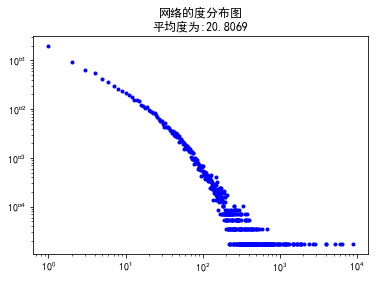

In [11]:
network=nx.read_adjlist("network_edgelist/allNetworkConnective0.5.txt")
degree=degree_graph_chinese(network,"pictures/allnetwork_degree.svg")

In [7]:
data_path='original_data/'
dis_gene_file = data_path+'DisGeNet_dis_gene.txt' #疾病基因网络
dis_symp_file = data_path+'HPO&Orphanet_dis_symp.txt' #疾病表型网络
gene_go_file = data_path+'homo_gene_GO.txt' #基因本体网络
ppi_file = data_path+'blab_ppi2016.txt' #ppi网络

dis_gene_edges=loadNet(dis_gene_file)
dis_symp_edges=loadNet(dis_symp_file)
gene_go_edges=loadNet(gene_go_file)
ppi_edges=loadNet(ppi_file)

In [8]:
dis_nodes,gene_nodes=getNodelist(dis_gene_file)
print("DisGeNet:\ndisease nums:{}\ngene nums:{}\ntotal nums:{}\nedges:{}\n\n".format(len(dis_nodes),len(gene_nodes),len(dis_nodes)+len(gene_nodes),len(dis_gene_edges)))
dis_nodes,symp_nodes=getNodelist(dis_symp_file)
print("HPO&Orphanet:\ndisease nums:{}\nsymptom nums:{}\ntotal nums:{}\nedges:{}\n\n".format(len(dis_nodes),len(symp_nodes),len(dis_nodes)+len(symp_nodes),len(dis_symp_edges)))
gene_nodes,go_nodes=getNodelist(gene_go_file)
print("homo_gene_GO:\ngene nums:{}\ngo nums:{}\ntotal nums:{}\nedges:{}\n\n".format(len(gene_nodes),len(go_nodes),len(dis_nodes)+len(go_nodes),len(gene_go_edges)))
gene_nodes1,gene_nodes2=getNodelist(ppi_file)
print("blab_ppi2016:\ngene nums:{}\ngene nums:{}\ntotal nums:{}\nedges:{}\n\n".format(len(gene_nodes1),len(gene_nodes2),len(gene_nodes1)+len(gene_nodes2),len(ppi_edges)))

DisGeNet:
disease nums:13074
gene nums:8947
total nums:22021
edges:130820


HPO&Orphanet:
disease nums:5423
symptom nums:6540
total nums:11963
edges:99087


homo_gene_GO:
gene nums:18584
go nums:14204
total nums:19627
edges:218337


blab_ppi2016:
gene nums:10810
gene nums:14996
total nums:25806
edges:213888




/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


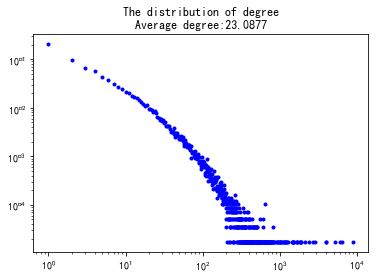

In [9]:
network = nx.Graph() # 创建无向图
network.add_edges_from(list(dis_gene_edges))
network.add_edges_from(list(dis_symp_edges))
network.add_edges_from(list(gene_go_edges))
network.add_edges_from(list(ppi_edges))
degree=degree_graph(network,"pictures/network_degree.svg")

In [38]:
transitivity=nx.transitivity(network)#图或网络的传递性。即图或网络中，认识同一个节点的两个节点也可能认识双方，计算公式为3*图中三角形的个数/三元组个数（该三元组个数是有公共顶点的边对数，这样就好数了）。
clustering=nx.clustering(network)
avg_clustering=sum(clustering.values())/len(clustering)
print("transitivity={}".format(transitivity))
print("avg_clustering={}".format(avg_clustering))

transitivity=0.019956104970846017
avg_clustering=0.060420911000412456


/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


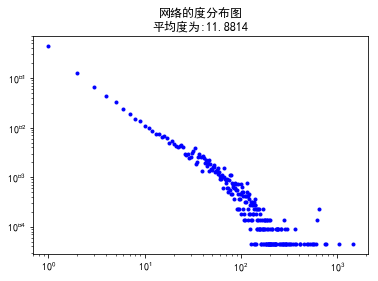

In [6]:
dis_gene_network = nx.Graph() # 创建无向图
dis_gene_network.add_edges_from(list(dis_gene_edges))
degree=degree_graph_chinese(dis_gene_network,"pictures/dis_gene_degree.svg")

In [34]:
transitivity=nx.transitivity(dis_gene_network)#图或网络的传递性。即图或网络中，认识同一个节点的两个节点也可能认识双方，计算公式为3*图中三角形的个数/三元组个数（该三元组个数是有公共顶点的边对数，这样就好数了）。
clustering=nx.clustering(dis_gene_network)
avg_clustering=sum(clustering.values())/len(clustering)
print("transitivity={}".format(transitivity))
print("avg_clustering={}".format(avg_clustering))

transitivity=0
avg_clustering=0.0


/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


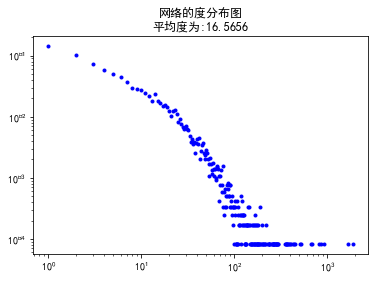

In [7]:
dis_symp_network = nx.Graph() # 创建无向图
dis_symp_network.add_edges_from(list(dis_symp_edges))
degree=degree_graph_chinese(dis_symp_network,"pictures/dis_symp_degree.svg")

In [35]:
transitivity=nx.transitivity(dis_symp_network)#图或网络的传递性。即图或网络中，认识同一个节点的两个节点也可能认识双方，计算公式为3*图中三角形的个数/三元组个数（该三元组个数是有公共顶点的边对数，这样就好数了）。
clustering=nx.clustering(dis_symp_network)
avg_clustering=sum(clustering.values())/len(clustering)
print("transitivity={}".format(transitivity))
print("avg_clustering={}".format(avg_clustering))

transitivity=0
avg_clustering=0.0


/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


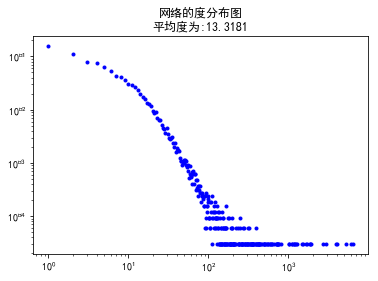

In [8]:
gene_go_network = nx.Graph() # 创建无向图
gene_go_network.add_edges_from(list(gene_go_edges))
degree=degree_graph_chinese(gene_go_network,"pictures/gene_go_degree.svg")

In [36]:
transitivity=nx.transitivity(gene_go_network)#图或网络的传递性。即图或网络中，认识同一个节点的两个节点也可能认识双方，计算公式为3*图中三角形的个数/三元组个数（该三元组个数是有公共顶点的边对数，这样就好数了）。
clustering=nx.clustering(gene_go_network)
avg_clustering=sum(clustering.values())/len(clustering)
print("transitivity={}".format(transitivity))
print("avg_clustering={}".format(avg_clustering))

transitivity=0
avg_clustering=0.0


/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/matplotlib/mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


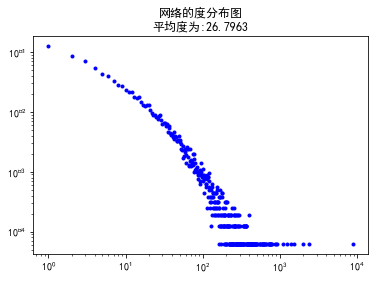

In [9]:
ppi = nx.Graph() # 创建无向图
ppi.add_edges_from(list(ppi_edges))
degree=degree_graph_chinese(ppi,"pictures/ppi_degree.svg")

In [33]:
transitivity=nx.transitivity(ppi)#图或网络的传递性。即图或网络中，认识同一个节点的两个节点也可能认识双方，计算公式为3*图中三角形的个数/三元组个数（该三元组个数是有公共顶点的边对数，这样就好数了）。
clustering=nx.clustering(ppi)
avg_clustering=sum(clustering.values())/len(clustering)
print("transitivity={}".format(transitivity))
print("avg_clustering={}".format(avg_clustering))
# largest_components= max(nx.connected_component_subgraphs(ppi), key=len)
# nx.average_shortest_path_length(largest_components)


transitivity=0.03269052636165511
avg_clustering=0.20246884166067755


In [11]:
import gc
negRatio = [0.5,1,1.5,2,2.5,3,3.5,4,4.5]
posEdgeFile="network_edgelist/connectiveSample_edges0.1.txt"
pos_edges,neg_edges=read_edges(posEdgeFile)
posSampleRation=0.1
filePredix="network_edgelist/connectiveSample_negPosRatio"
for sampleRatio in negRatio:
    dis_gene_network = nx.Graph() # 创建无向图
    dis_gene_network.add_edges_from(list(dis_gene_edges))
    savePath=filePredix+str(sampleRatio)+".txt"
    neg_edges=sampleNegativeEdge(dis_gene_network,sampleRatio=0.1*sampleRatio)
    save_edges(savePath,pos_edges,neg_edges)
    del neg_edges,dis_gene_network
    count=gc.collect()

19623
26164
32705
39246
45787
52328
58869
65410
71951


In [12]:
posSampleRatio=[x/10 for x in range(1,10)]
filePredix="network_edgelist/connectiveSample_edges"
i=0
for sampleRatio in posSampleRatio:
    dis_gene_network = nx.Graph() # 创建无向图
    dis_gene_network.add_edges_from(list(dis_gene_edges))
#     print(i,len(dis_gene_network.nodes))
    i+=1
    saveSampleConnectivePath="network_edgelist/connectiveSample_edges"+str(sampleRatio)+".txt"
    neg_edges=sampleNegativeEdge(dis_gene_network,sampleRatio)
    dis_gene_network_connective, pos_edges = mst_drop(dis_gene_network, sampleRatio)
    pos_edges=list(map(lambda x:tuple(x),pos_edges))
    save_edges(saveSampleConnectivePath,pos_edges,neg_edges)
    
    #异构网络
    #d:disease,g:gene,s:symptom,p:protein,o:GO
    dis_gene_network_connective.add_edges_from(dis_symp_edges)
    dis_gene_network_connective.add_edges_from(ppi_edges)
    dis_gene_network_connective.add_edges_from(gene_go_edges)
    nx.write_adjlist(dis_gene_network_connective, "network_edgelist/allNetworkConnective"+str(sampleRatio)+".txt")

22021
26164
22021
52328
22021
78492
22021
104656
22021
130820
22021
156984
22021
183148
22021
209312
22021
235476


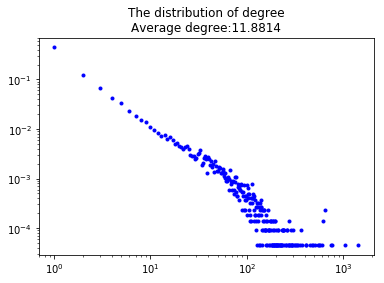

22021
130820


In [6]:
dis_gene_network = nx.Graph() # 创建无向图
dis_gene_network.add_edges_from(list(dis_gene_edges))
# degree=degree_graph(dis_gene_network)
print(len(dis_gene_network.nodes))
saveSampleConnectivePath="network_edgelist/connectiveSample_edges0.5.txt"
neg_edges=sampleNegativeEdge(dis_gene_network,sampleRatio=0.5)
dis_gene_network_connective, pos_edges = mst_drop(dis_gene_network, drop_ratio=0.5)
pos_edges=list(map(lambda x:tuple(x),pos_edges))
save_edges(saveSampleConnectivePath,pos_edges,neg_edges)
# nx.write_edgelist(remainGraph, "network_edgelist/dg_sampledGraph_connective_adjlist.txt", delimiter=' ',data=False)
#nx.write_adjlist(remainGraph,"./network_edgelist/dg_sampledGraph_connective_adjlist.txt")
# print(len(list(dis_gene_network_connective.edges)))
# print(len(pos_edges))
# print(len(neg_edges))

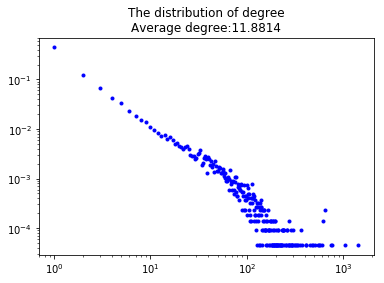

In [11]:
dis_gene_network = nx.Graph() # 创建无向图
dis_gene_network.add_edges_from(list(dis_gene_edges))
degree=degree_graph(dis_gene_network,"pictures/dis_gene_network.svg")

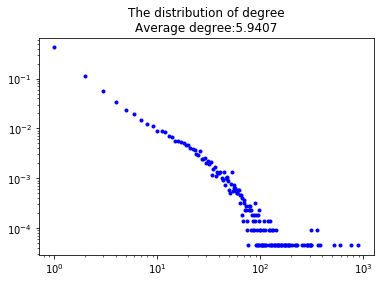

In [12]:
degree=degree_graph(dis_gene_network_connective,"pictures/dis_gene_connective.svg")

In [8]:
dis_gene_network = nx.Graph() # 创建无向图
dis_gene_network.add_edges_from(list(dis_gene_edges))
print(len(dis_gene_network.nodes))
saveSampleRandomPath="network_edgelist/randomSample_edges0.5.txt"
dis_gene_network_random, pos_edges_rand = random_drop(dis_gene_network, drop_ratio=0.5)
save_edges(saveSampleRandomPath,pos_edges_rand,neg_edges)
print(len(list(dis_gene_network_random.edges)))
print(len(pos_edges))
print(len(neg_edges))

22021
130820
65410
65410
65410


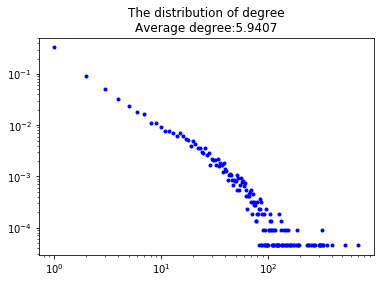

In [13]:
degree=degree_graph(dis_gene_network_random,"pictures/dis_gene_random.svg")

In [14]:
#不同组合的异构网络(连通性采样方法)
#d:disease,g:gene,s:symptom,p:protein,o:GO
dg_network=dis_gene_network_connective.copy()
dgs_network =dg_network.copy()
dgs_network.add_edges_from(dis_symp_edges)
dgp_network=dg_network.copy()
dgp_network.add_edges_from(ppi_edges)
dgpo_network=dgp_network.copy()
dgpo_network.add_edges_from(gene_go_edges)
dgsp_network=dgs_network.copy()
dgsp_network.add_edges_from(ppi_edges)
all_network=dgsp_network.copy()
all_network.add_edges_from(gene_go_edges)

nx.write_adjlist(dg_network, "network_edgelist/dg_network_adjlist_connective.txt")
nx.write_adjlist(dgs_network, "network_edgelist/dgs_network_adjlist_connective.txt")
nx.write_adjlist(dgp_network, "network_edgelist/dgp_network_adjlist_connective.txt")
nx.write_adjlist(dgpo_network, "network_edgelist/dgpo_network_adjlist_connective.txt")
nx.write_adjlist(dgsp_network, "network_edgelist/dgsp_network_adjlist_connective.txt")
nx.write_adjlist(all_network, "network_edgelist/all_network_adjlist_connective.txt")

In [15]:
#不同组合的异构网络(随机采样方法)
#d:disease,g:gene,s:symptom,p:protein,o:GO
dg_edges=dis_gene_network_random.copy()
dgs_network =dg_network.copy()
dgs_network.add_edges_from(dis_symp_edges)
dgp_network=dg_network.copy()
dgp_network.add_edges_from(ppi_edges)
dgpo_network=dgp_network.copy()
dgpo_network.add_edges_from(gene_go_edges)
dgsp_network=dgs_network.copy()
dgsp_network.add_edges_from(ppi_edges)
all_network=dgsp_network.copy()
all_network.add_edges_from(gene_go_edges)


nx.write_adjlist(dg_network, "network_edgelist/dg_network_adjlist_random.txt")
nx.write_adjlist(dgs_network, "network_edgelist/dgs_network_adjlist_random.txt")
nx.write_adjlist(dgp_network, "network_edgelist/dgp_network_adjlist_random.txt")
nx.write_adjlist(dgpo_network, "network_edgelist/dgpo_network_adjlist_random.txt")
nx.write_adjlist(dgsp_network, "network_edgelist/dgsp_network_adjlist_random.txt")
nx.write_adjlist(all_network, "network_edgelist/all_network_adjlist_random.txt")

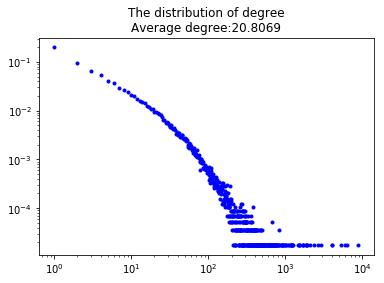

In [16]:
degree=degree_graph(all_network,"pictures/all_net_degree.svg")